In [1]:
import os
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from wrf import to_np, getvar, CoordPair, vertcross, latlon_coords,interpline, interplevel, get_cartopy,  xy_to_ll, ll_to_xy, smooth2d
import wrf
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import interp1d
import glob
import xarray as xr
from scipy.ndimage import gaussian_filter
from matplotlib.cm import get_cmap
from statistics import multimode, mode
#Acceleration of gravity (constant) for converting to geopotential height
g = 9.8

In [2]:
########### what pressure level do we want to view with our plots, if any ###

contour = False

if contour == True:
    p_lvl = 850
    
########### Define the colors in the desired sequence for IVT: ###########

colors = ['#FFFF00', '#FFEE00','#FFDC00', '#FFB700',
          '#FFA300', '#FF9000', '#FF7D00', '#FF6800',
          '#FF5200', '#C70039','#900C3F', (.88,.24,.69)]

############## Create a colormap using ListedColormap #################

cmap = mcolors.ListedColormap(colors)
pmsl_levels = np.arange(960, 1060, 4)
# dark brown for state/coastlines
dark_brown = (0.4, 0.2, 0)
ivt_levels = np.arange(250,1150,100)

In [3]:
#Name of file to create cross section from

datafiles = (glob.glob("/scratch/sawyer/wwrf/2017-01-09/p3_2nd/wrfout_d01_2017-01-08_03:00:00"))
datafiles.sort()
numfiles=len(datafiles)
ncfile = Dataset(datafiles[0])

# Function to extract characters between 5th and 6th "/"
def extract_segment(filepath):
    parts = filepath.split('/')
    if len(parts) > 6:
        return parts[5]  # Return the 6th segment (0-indexed)
    else:
        return None  # Return None if there aren't enough segments

# Extracting segments from each file in the list
#ensemble_member = [extract_segment(file) for file in datafiles]
ensemble_member = 'p3_2nd'

In [4]:
# Function to extract the date from the file name
def extract_date(filepath):
    # Split the path by '/'
    parts = filepath.split('/')
    
    # Extract the last part of the path
    last_segment = parts[-1]
    
    # Further split to get the date
    date_segment = last_segment.split('_')[-1]
    
    return date_segment

# Extracting the date from each file in the list
dates = [extract_date(file) for file in datafiles]

# Assuming you want to assign the date from the first file to a variable
date = dates[0] if dates else None

print(date)

03:00:00


In [5]:
Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
timestr=(str(Time))

# Set up one time string for plot titles, another for file names

titletime=(timestr[0:10]+' '+timestr[11:13]+timestr[14:16])
filetime=(timestr[0:10]+'_'+timestr[11:13])

# Get all the variables we need
z = getvar(ncfile, "z")
p = getvar(ncfile, "pressure")*100
inter_p = getvar(ncfile, "pressure")
pvo = getvar(ncfile, "pvo")
slp = getvar(ncfile, "slp")
smooth_slp = gaussian_filter(slp, 3)
terrain = getvar(ncfile, "ter")
t = getvar(ncfile, 'tc')
#### Below is for cross section ########################
pov = pvo
print(pov.shape)
# Apply a Gaussian filter with a standard deviation of n pixels
filtered_pv = gaussian_filter(pov, sigma=1)

theta = getvar(ncfile, 'th')
wdsp = getvar(ncfile,'uvmet_wspd', units='kts')
print(wdsp.shape)
ph = getvar(ncfile, "PH") # get geopotential perturbation 
phb = getvar(ncfile, "PHB") # get geopotential base state 
geo_pot = ph + phb #Add base state and perturbation to get geopotential height
geo_pot = (geo_pot / 9.8) / 1000 #Convert value to km
z_notop = geo_pot[0:59,:,:]
print(z_notop.shape)
h_diabatic = getvar(ncfile, 'H_DIABATIC')
rthcuten = getvar(ncfile,'RTHCUTEN')
lh =h_diabatic+rthcuten
#filtered_wdsp = gaussian_filter(wdsp, sigma=2)
#print(wdsp.shape)
#w =  getvar(ncfile, 'W')
#print(w.shape)
#ice = getvar(data, 'QICE')
#vapor = getvar(ncfile, 'QVAPOR')[0:35,:,:]*1000
#print(vapor.max)
#graup = getvar(data, 'QGRAUP')
#snow = getvar(data, 'QSNOW')


#ua_kts = getvar(ncfile, "ua", units = "kt")
#va_kts = getvar(ncfile, "va",units = "kt")
ua = getvar(ncfile, "ua")
va = getvar(ncfile, "va")
wspd = getvar(ncfile, "wspd_wdir")[0,:]

mixing_ratio = ncfile['QVAPOR'][0,:,:,:]

uflux_l = []
vflux_l = []

for m in range(0,len(mixing_ratio)-2):
    layer_diff = p[m,:,:]-p[m+1,:,:]
    ql = (mixing_ratio[m+1,:,:]+mixing_ratio[m,:,:])/2
    ul = (ua[m+1,:,:]+ua[m,:,:])/2
    vl = (va[m+1,:,:]+va[m,:,:])/2
    qfl = (ql/9.8)*layer_diff
    uflux= ul * qfl
    vflux = vl * qfl
    uflux_l.append(uflux)
    vflux_l.append(vflux)

uflux_l=np.asarray(uflux_l)
vflux_l=np.asarray(vflux_l)
uIVT = np.sum(uflux_l, axis = 0)
vIVT = np.sum(vflux_l, axis = 0)
IVT_tot=np.sqrt(uIVT**2+vIVT**2)
#IVT_tot=xr.DataArray(IVT_tot,dims=['lat','lon'])

(59, 569, 618)
(59, 569, 618)
(59, 569, 618)


In [6]:
if contour == True:
    # Interpolate geopotential height, u, and v winds to pressure level
    ht = interplevel(z, inter_p, p_lvl)
    u = interplevel(ua, inter_p, p_lvl)
    v = interplevel(va, inter_p, p_lvl)
    wspd_inter = interplevel(wspd, inter_p, p_lvl)
    print(wspd_inter.max())

# Get the lat/lon coordinates
lats, lons = latlon_coords(z)

## WWRF longitude fix ######
new_lons =np.where(lons > 0, lons - 360, lons)


In [7]:
# Function to plot a line at a specified angle and midpoint, modified to return endpoints
def get_axis_coords(midpoint, length, angle_degrees):
    x_mid, y_mid = midpoint
    angle_radians = np.radians(angle_degrees)

    # Calculate delta x and delta y based on the angle
    delta_x = (length / 2) * np.cos(angle_radians)
    delta_y = (length / 2) * np.sin(angle_radians)

    # Calculate the endpoints
    x1, y1 = x_mid - delta_x, y_mid - delta_y
    x2, y2 = x_mid + delta_x, y_mid + delta_y

    return [x1, y1, x2, y2]

In [8]:
lon_mid = -131
lat_mid = 30
length = 25
angle = 40
axis = get_axis_coords((lon_mid,lat_mid),length,angle)
x1, x2 = axis[0], axis[2]
y1, y2 = axis[1], axis[3]

-140.57555553898723
-121.42444446101277


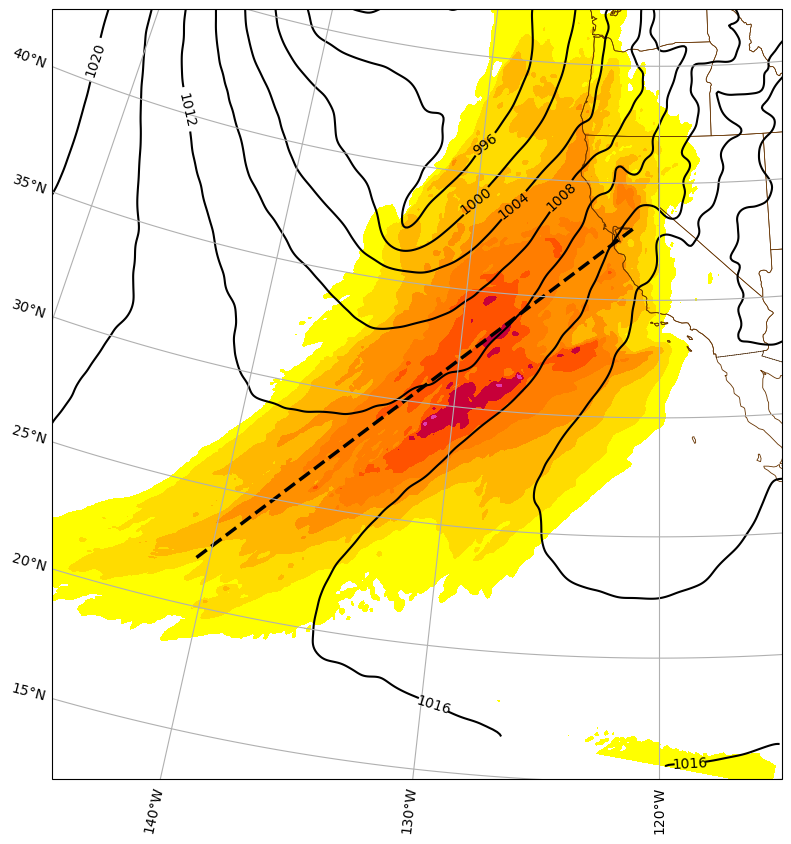

In [9]:
# Take a quick look at our axis
# Get the cartopy mapping object
lcc_projection = ccrs.LambertConformal(
    central_longitude=-120.0)

fig, ax = plt.subplots(figsize=(14,10), subplot_kw={'projection': lcc_projection})
ax.set_extent([-145, -115, 15, 45])
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor=dark_brown)
ax.coastlines('50m', linewidth=0.6, color=dark_brown)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)#Add coastlines


cs = ax.contourf(to_np(new_lons), to_np(lats), to_np(IVT_tot), cmap = cmap, levels = ivt_levels, transform=ccrs.PlateCarree())
cp = ax.contour(to_np(new_lons), to_np(lats), to_np(smooth_slp), colors='black', levels = pmsl_levels, transform=ccrs.PlateCarree())
ax.clabel(cp, fmt='%1.0f', inline=True,levels=pmsl_levels)
ax.plot([axis[0], axis[2]], [axis[1],axis[3]], color = 'black', linewidth=2.5,linestyle='--', transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels

In [20]:
# Calculate the slope of the original line
slope = (y2 - y1) / (x2 - x1)

# Calculate the negative reciprocal (perpendicular slope)
perp_slope = -1 / slope if slope != 0 else float('inf')  # Check for vertical line

# Use np.linspace to calculate midpoints
# make adjustments to midpoint slider below; (e.g. to slide further northeast, slider would corresponde to values > 0.5
# 0.5 is midpoint of axis
slider = 0.49
width = 0.017
num = 40
midpoints_x = np.linspace((x1 + x2) * (slider - width), (x1 + x2) * (slider + width), num=num)

# Define the length of each perpendicular line from its midpoint
southern_perp_line_length = 4.5
northern_perp_line_length = 10.
# Prepare a list to store the endpoints of each perpendicular line
perpendicular_line_endpoints = []
# Iterate through the calculated midpoints
for mid_x in midpoints_x:
    mid_y = (mid_x - x1) * slope + y1  # Calculate corresponding mid_y based on the original line's slope

    # Define the x-range for the perpendicular line to ensure it's within the grid
    if perp_slope != float('inf'):  # Regular case, not a vertical line
        x_range = np.linspace(mid_x - northern_perp_line_length, mid_x + southern_perp_line_length, 2)
        # Define the perpendicular line's y-coordinates based on the perpendicular slope
        y_perp = perp_slope * (x_range - mid_x) + mid_y
    else:  # Special case for a vertical line
        x_range = [mid_x, mid_x]
        y_perp = [mid_y - perp_line_length, mid_y + perp_line_length]
        
    # Store the start and end points of the perpendicular line
    start_point = (x_range[0], y_perp[0])
    end_point = (x_range[1], y_perp[1])
    perpendicular_line_endpoints.append((start_point, end_point))

# Now you have the start and end points of each perpendicular line stored
# The following lines will print them
#print(perpendicular_line_endpoints)
#for line in perpendicular_line_endpoints:
    #print(f"Perpendicular line start point: {line[0]}, end point: {line[1]}")

[((-133.926, 47.853326716890194), (-119.42599999999999, 30.572899624274143)), ((-134.15441025641024, 47.661667754979234), (-119.65441025641024, 30.381240662363183)), ((-134.3828205128205, 47.47000879306828), (-119.8828205128205, 30.18958170045223)), ((-134.61123076923076, 47.27834983115733), (-120.11123076923076, 29.997922738541277)), ((-134.83964102564101, 47.086690869246375), (-120.33964102564101, 29.806263776630324)), ((-135.06805128205127, 46.89503190733542), (-120.56805128205127, 29.61460481471937)), ((-135.29646153846153, 46.70337294542446), (-120.79646153846153, 29.42294585280841)), ((-135.52487179487179, 46.51171398351351), (-121.02487179487179, 29.231286890897458)), ((-135.75328205128204, 46.320055021602556), (-121.25328205128204, 29.039627928986505)), ((-135.9816923076923, 46.1283960596916), (-121.4816923076923, 28.847968967075552)), ((-136.21010256410256, 45.93673709778065), (-121.71010256410256, 28.6563100051646)), ((-136.4385128205128, 45.74507813586969), (-121.93851282051

Text(1.0, 1.0, 'VALID: 2017-01-08 0300Z')

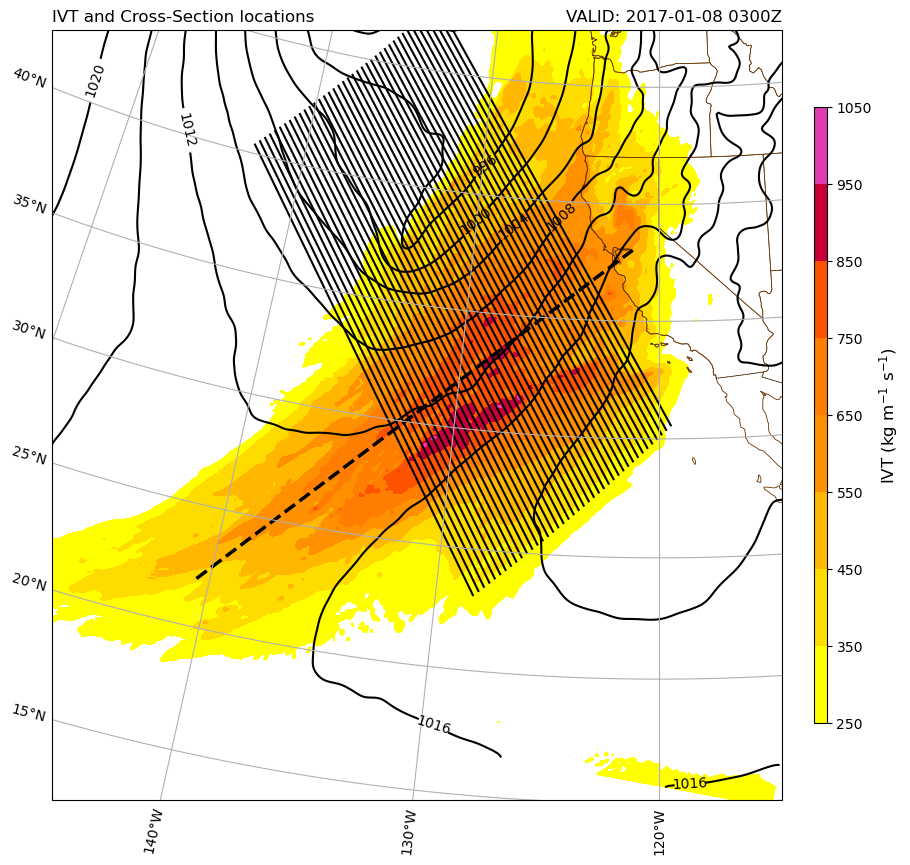

In [11]:
pmsl_levels = np.arange(960, 1060, 4)
# dark brown for state/coastlines
dark_brown = (0.4, 0.2, 0)
"""
Plot AR IVT to get an idea of horizontal placement, and overlay the coordinates of our cross section.
"""
# Get the cartopy mapping object
lcc_projection = ccrs.LambertConformal(
    central_longitude=-120.0)

fig, ax = plt.subplots(figsize=(14,10), subplot_kw={'projection': lcc_projection})
ax.set_extent([-145, -115, 15, 45])
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor=dark_brown)
ax.coastlines('50m', linewidth=0.6, color=dark_brown)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)#Add coastlines


cs = ax.contourf(to_np(new_lons), to_np(lats), to_np(IVT_tot), cmap = cmap, levels = ivt_levels, transform=ccrs.PlateCarree())
cp = ax.contour(to_np(new_lons), to_np(lats), to_np(smooth_slp), colors='black', levels = pmsl_levels, transform=ccrs.PlateCarree())
ax.clabel(cp, fmt='%1.0f', inline=True,levels=pmsl_levels)
ax.plot([x1, x2], [y1,y2], color = 'black', linewidth=2.5,linestyle='--', transform=ccrs.PlateCarree())
#ax.plot(x_range, y_perp, label='Perpendicular Line',color = 'black', transform=ccrs.PlateCarree())
#ax.plot([x_range[0],x_range[-1]], [y_perp[0],y_perp[-1]], label='Perpendicular Line',color = 'black', transform=ccrs.PlateCarree())
# Plot each perpendicular line
for start_point, end_point in perpendicular_line_endpoints:
    ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color='black', transform=ccrs.PlateCarree())

cbar = plt.colorbar(cs, ax=ax, orientation="vertical", pad=.03, shrink=.8, aspect=50)
cbar.set_label("IVT (kg m$^{-1}$ s$^{-1}$)", fontsize = 12)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels
# Titles
plt.title('IVT and Cross-Section locations ',loc='left')
plt.title(f'VALID: {titletime}Z', loc='right')

#fig.savefig('3km_moving_nest_IVT_2012_12_23_06z.png',
            #bbox_inches='tight',transparent=False,facecolor='white')

In [21]:
array_shape = []

for start_point, end_point in perpendicular_line_endpoints:
    
    # Assuming lat1 and lat2 are constants that you've defined elsewhere
    start_point_coords = CoordPair(lat=start_point[1], lon=start_point[0]) # Start point
    end_point_coords = CoordPair(lat=end_point[1], lon=end_point[0]) # End point
    
    #print(start_point_coords)
    wdspp_cross = vertcross(wdsp, z_notop, wrfin=ncfile, start_point=start_point_coords,
                           end_point=end_point_coords, latlon=True, meta=True)
    
    
    shape = wdspp_cross.shape[1] 
   
    first_shape = wdspp_cross.shape[0] 
    array_shape.append(shape) # Add the number of data points to the list

# Determine the target size for the second dimension
# For example, using the average size
min_size = np.min(array_shape)

CoordPair(lat=47.853326716890194, lon=-133.926)
CoordPair(lat=47.661667754979234, lon=-134.15441025641024)
CoordPair(lat=47.47000879306828, lon=-134.3828205128205)
CoordPair(lat=47.27834983115733, lon=-134.61123076923076)
CoordPair(lat=47.086690869246375, lon=-134.83964102564101)
CoordPair(lat=46.89503190733542, lon=-135.06805128205127)
CoordPair(lat=46.70337294542446, lon=-135.29646153846153)
CoordPair(lat=46.51171398351351, lon=-135.52487179487179)
CoordPair(lat=46.320055021602556, lon=-135.75328205128204)
CoordPair(lat=46.1283960596916, lon=-135.9816923076923)
CoordPair(lat=45.93673709778065, lon=-136.21010256410256)
CoordPair(lat=45.74507813586969, lon=-136.4385128205128)
CoordPair(lat=45.553419173958744, lon=-136.66692307692307)
CoordPair(lat=45.361760212047784, lon=-136.89533333333333)
CoordPair(lat=45.17010125013683, lon=-137.12374358974358)
CoordPair(lat=44.97844228822588, lon=-137.35215384615384)
CoordPair(lat=44.786783326314925, lon=-137.5805641025641)
CoordPair(lat=44.595124

In [13]:
#klevs correspond to plevs below for reference
plevs  = [1000,950,900,850,800,750,700,650,600,55000.,50000.,45000.,
         40000.,35000.,30000.,25000.,20000.,15000.,12500.,10000., 7500., 6000.]
klev = 3
level = plevs[klev]
print(level)
hour = '12'
day = 8
# Get a list of all .npy files in the directory
file = f'/scratch/sawyer/wwrf/2017-01-09/ensemble_data/pv/pvntnd/pvntnd_p3_3mom_2017-01-0{day}_{hour}.npy'
pvntnd_arr = np.load(file, allow_pickle=True)
print(pvntnd_arr.shape)

850
(569, 618, 22)


In [25]:
first_shape =100
thet = np.zeros([first_shape,min_size])
pv = np.zeros([first_shape,min_size])
wind = np.zeros([first_shape,min_size])
heat = np.zeros([first_shape,min_size])
pvntnd = np.zeros([first_shape,min_size])
hgt= np.zeros([min_size])
temp = np.zeros([first_shape,min_size])
#print(wind.shape)


top_lon = []
bott_lon = []
top_lat = []
bott_lat = []
new_num = len(top_lon)

for start_point, end_point in perpendicular_line_endpoints:
    # Assuming lat1 and lat2 are constants that you've defined elsewhere
    start_point = CoordPair(lat=start_point[1], lon=start_point[0]) # Start point
    end_point= CoordPair(lat=end_point[1], lon=end_point[0]) # End point
    
    print(start_point, end_point)

    wdsp_cross = vertcross(wdsp, z_notop, wrfin=ncfile, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True)
    #print(wdsp_cross.shape)
    
    pv_cross = vertcross(pov, z_notop, wrfin=ncfile, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

    th_cross = vertcross(theta, z_notop, wrfin=ncfile, start_point=start_point,
                     end_point=end_point, latlon=True, meta=True)

    h_cross = vertcross(lh, z_notop, wrfin=ncfile, start_point=start_point,
                   end_point=end_point, latlon=True, meta=True)
    
    t_cross = vertcross(t, z_notop, wrfin=ncfile, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
    
    # Get the terrain heights along the cross section line
    ter_line = interpline(terrain, wrfin=ncfile, start_point=start_point,
                      end_point=end_point, latlon=True, meta=True)
    #print("terrain shape: ", ter_line.shape[0])

    # Trim the arrays if their second dimension is greater than min_size
    if wdsp_cross.shape[1] > min_size:
        wdsp_cross = wdsp_cross[:, :min_size]
    if pv_cross.shape[1] > min_size:
        pv_cross = pv_cross[:, :min_size]
    if th_cross.shape[1] > min_size:
        th_cross = th_cross[:, :min_size]
    if h_cross.shape[1] > min_size:
        h_cross = h_cross[:, :min_size]
    
    if t_cross.shape[1] > min_size:
        t_cross = t_cross[:, :min_size]
    if ter_line.shape[0] > min_size:
        ter_line = ter_line[:min_size]
 
    wind += wdsp_cross.values
    pv += pv_cross.values
    thet += th_cross.values
    heat += h_cross.values
    temp += t_cross.values
    hgt +=ter_line.values
    top_lat.append(strt_point[1])
    top_lon.append(strt_point[0])
    bott_lon.append(ed_point[0])
    bott_lat.append(ed_point[1])

    

CoordPair(lat=47.853326716890194, lon=-133.926) CoordPair(lat=30.572899624274143, lon=-119.42599999999999)
0.8170080780982971
CoordPair(lat=47.661667754979234, lon=-134.15441025641024) CoordPair(lat=30.381240662363183, lon=-119.65441025641024)
1.6292064785957336
CoordPair(lat=47.47000879306828, lon=-134.3828205128205) CoordPair(lat=30.18958170045223, lon=-119.8828205128205)
2.403386950492859
CoordPair(lat=47.27834983115733, lon=-134.61123076923076) CoordPair(lat=29.997922738541277, lon=-120.11123076923076)
3.032418191432953
CoordPair(lat=47.086690869246375, lon=-134.83964102564101) CoordPair(lat=29.806263776630324, lon=-120.33964102564101)
3.5406455993652344
CoordPair(lat=46.89503190733542, lon=-135.06805128205127) CoordPair(lat=29.61460481471937, lon=-120.56805128205127)
3.9474900364875793
CoordPair(lat=46.70337294542446, lon=-135.29646153846153) CoordPair(lat=29.42294585280841, lon=-120.79646153846153)
4.39396333694458
CoordPair(lat=46.51171398351351, lon=-135.52487179487179) CoordPa

In [26]:

theta_avg = thet / num
#theta_avg = gaussian_filter(theta_avg, sigma=1)
pv_avg = pv / num
#pv_avg = gaussian_filter(pv_avg, sigma=1)
wind_avg = wind / num
diabatic_h = heat / num
t_avg = hgt/num
temp_avg = temp / num

0.9938662420958281
277.7336540222168


'\nlh_save_directory = "/scratch/sawyer/wwrf/2017-01-09/cross_sections/h_diab_vert"\npv_save_directory = "/scratch/sawyer/wwrf/2017-01-09/cross_sections/pv_vert/"\nsave_directory="/scratch/sawyer/wwrf/2017-01-09/cross_sections/theta_vert/"\ntemp_save_directory="/scratch/sawyer/wwrf/2017-01-09/cross_sections/temp/"\n\nlh_name = f"total_lh_{ensemble_member}_08_{date}.npy"\n# Use the specified save directory for the numpy files\nlh_save_path = os.path.join(lh_save_directory, lh_name)\n\npv_name = f"total_pv_{ensemble_member}_08_{date}.npy"\n# Use the specified save directory for the numpy files\npv_save_path = os.path.join(pv_save_directory, pv_name)\n\ntemp_name = f"temp_{ensemble_member}_08_{date}.npy"\n# Use the specified save directory for the numpy files\ntemp_save_path = os.path.join(temp_save_directory, temp_name)\n\ntheta_name = f"total_theta_{ensemble_member}_08_{date}.npy"\n# Use the specified save directory for the numpy files\nsave_path = os.path.join(save_directory, theta_nam

50


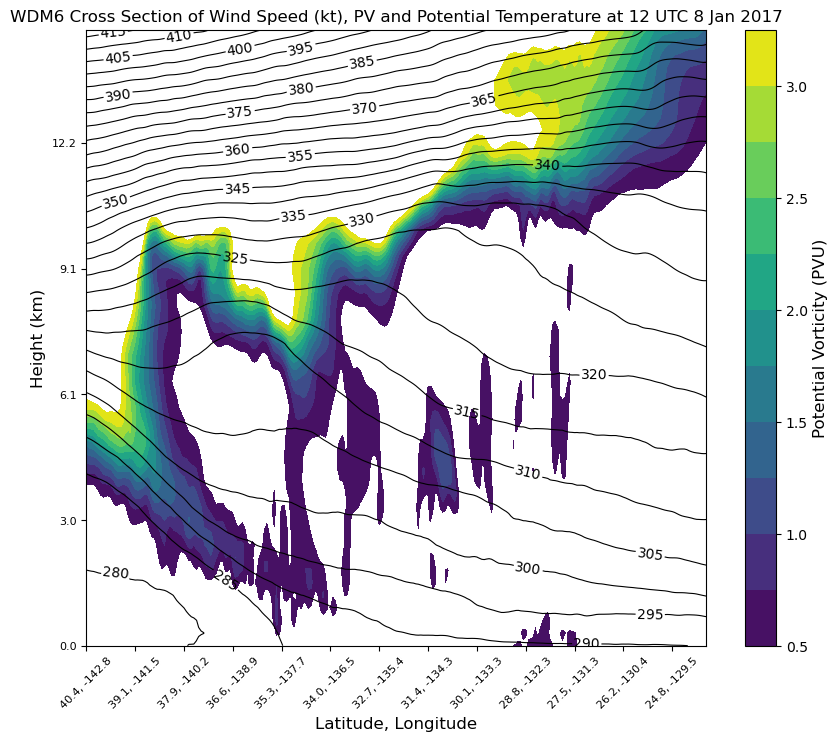

In [16]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes()
wdsp_lvls = np.arange(20,120,10)
#mixlvls = np.arange(0,12, 2)
th_lvls = np.arange(280, 450, 5)
#pv_lvls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
pv_lvls = np.arange(0.5,3.5,0.25)
# Contours -- make sure to modify levels here


th_contours = ax.contour(to_np(theta_avg[:50,:]), levels = th_lvls, colors = 'black', linestyles='-',linewidths=.8)
ax.clabel(th_contours, fmt='%1.f')


pv_cont = ax.contourf(to_np(pv_avg[:50,:]), levels = pv_lvls, cmap='viridis')
#hgt_cont = ax.contourf(to_np(t_avg), cmap='terrain')
#ax.clabel(pv_cont, fmt='%1.1f')

#cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
cbar = plt.colorbar(pv_cont) #cax = cax)
cbar.set_label("Potential Vorticity (PVU)", fontsize = 12)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(wdsp_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.1f}, {:.1f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])
ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)


# Set the y-ticks to be height.
vert_vals = to_np(wdsp_cross.coords["vertical"])
vert_values = np.round(vert_vals, 1)
start_idx = 50#len(vert_vals) // 2
print(start_idx)

# Update vert_vals to include only the top half
vert_vals_half = vert_vals[:start_idx]

# Set the y-ticks to be the top half of the height values
v_ticks_half = np.arange(len(vert_vals_half))
ax.set_yticks(v_ticks_half[::10])
ax.set_yticklabels(np.round(vert_vals_half, 1)[::10], fontsize=8)

#plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)

# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude, Longitude", fontsize=12)
ax.set_ylabel("Height (km)", fontsize=12)

plt.title("WDM6 Cross Section of Wind Speed (kt), PV and Potential Temperature at 12 UTC 8 Jan 2017")

plt.show()

In [17]:
lljet= wind_avg[0:30,:]

lljet.shape
lljet.max()

117.53016967773438

50


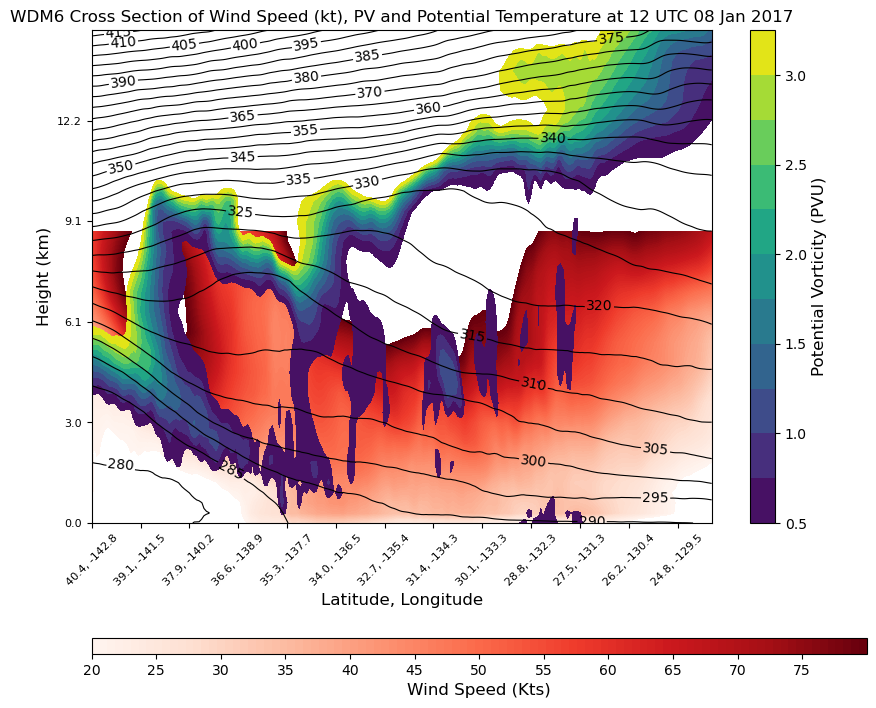

In [18]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes()

llj = np.linspace(20,80.0,100)
pv_lvls = np.arange(0.5,3.35,0.25)
# Contours -- make sure to modify levels here

llj_contours = ax.contourf(to_np(lljet), levels = llj, cmap= get_cmap("Reds"), alpha=1)

# Create the colorbar
cb = plt.colorbar(llj_contours, orientation='horizontal', pad=0.05, aspect=50, shrink=0.5, ax=ax)
colorbar_labels = np.arange(20, 80, 5)  # 80 is used to ensure 75 is included in the array

# Set the tick labels for the colorbar
cb.set_ticks(colorbar_labels)
cb.set_ticklabels(colorbar_labels)
# Optional: Set the label for the colorbar
cb.set_label('Wind Speed (Kts)', fontsize=12)

# Move the colorbar to the bottom of the plot.
# The `pad` argument controls the distance from the bottom of the plot, adjust as needed.
cb.ax.set_position([ax.get_position().x0, 0.1, ax.get_position().width, 0.02])
#wdsp_contours = ax.contour(to_np(wind_avg), levels = wdsp_lvls, linewidths=.8, colors = 'red')
#ax.clabel(wdsp_contours, fmt='%1.f')

th_contours = ax.contour(to_np(theta_avg[:50,:]), levels = th_lvls, colors = 'black', linestyles='-',linewidths=.8)
ax.clabel(th_contours, fmt='%1.f')


pv_cont = ax.contourf(to_np(pv_avg[:50,:]), levels = pv_lvls, cmap='viridis')
#ax.clabel(pv_cont, fmt='%1.1f')

#cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
cbar = plt.colorbar(pv_cont) #cax = cax)
cbar.set_label("Potential Vorticity (PVU)", fontsize = 12)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(th_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.1f}, {:.1f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])
ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)

# Set the y-ticks to be height.
vert_vals = to_np(wdsp_cross.coords["vertical"])
vert_values = np.round(vert_vals, 1)
start_idx = 50#len(vert_vals) // 2
print(start_idx)

# Update vert_vals to include only the top half
vert_vals_half = vert_vals[:start_idx]

# Set the y-ticks to be the top half of the height values
v_ticks_half = np.arange(len(vert_vals_half))
ax.set_yticks(v_ticks_half[::10])
ax.set_yticklabels(np.round(vert_vals_half, 1)[::10], fontsize=8)

# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude, Longitude", fontsize=12)
ax.set_ylabel("Height (km)", fontsize=12)

plt.title("WDM6 Cross Section of Wind Speed (kt), PV and Potential Temperature at 12 UTC 08 Jan 2017")

plt.show()

50


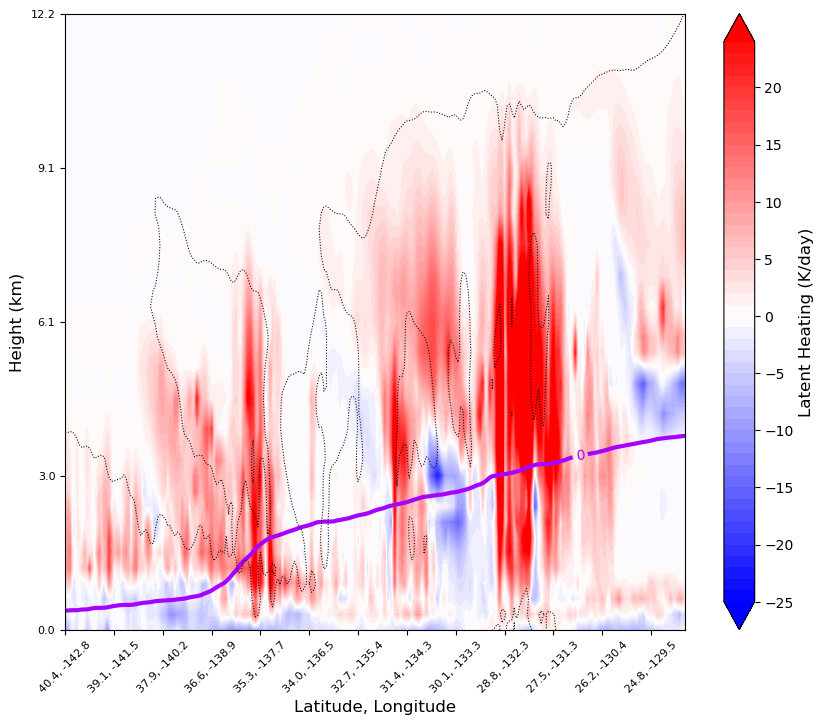

In [19]:
########### Diabatic heating Cross-Section average ############
from matplotlib.colors import TwoSlopeNorm
fig = plt.figure(figsize=(10,8))
ax = plt.axes()
l4 = ax.contour(to_np(temp_avg), colors = ('#a503fc',), levels = np.arange(0,1, 1), linewidths = 3)
# Calculate the maximum absolute difference to determine the color bar limits
max_diff = np.abs(h_cross*86400).max()

# Set the color bar limits symmetrically around zero

vmin, vmax, vcenter = -25, 25, 0

# Create a TwoSlopeNorm. This norm allows us to have a different color
# intensity rate below and above the center.
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
ax.clabel(l4)
cs = ax.contourf(to_np(diabatic_h[:50,:]*86400), cmap = 'bwr',extend='both', norm=norm, levels = np.arange(-25, 25, 1))
pv_cont = ax.contour(to_np(pv_avg[:50,:]), levels = [.5], colors='black',linewidths = 0.75,linestyles=':')
#pv_contf = ax.contourf(to_np(pv_avg[:50,:]), levels = [.5,1,1.5,2,2.5,3,3.5,4,4.5,5.,5.5,6.0,6.5], alpha=0.5,cmap='Greys_r',linewidths = 0.75,linestyles=':')
cbar = plt.colorbar(cs) 
cbar.set_label("Latent Heating (K/day)", fontsize = 12)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(th_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.1f}, {:.1f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])
ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)

# Set the y-ticks to be height.
vert_vals = to_np(wdsp_cross.coords["vertical"])
vert_values = np.round(vert_vals, 1)
start_idx = 50#len(vert_vals) // 2
print(start_idx)

# Update vert_vals to include only the top half
vert_vals_half = vert_vals[:start_idx]
# After plotting data, set the y-axis limit to match the data range
ax.set_ylim(0, np.max(vert_vals_half))  
# Set the y-ticks to be the top half of the height values
v_ticks_half = np.arange(len(vert_vals_half))
ax.set_yticks(v_ticks_half[::10])
ax.set_yticklabels(np.round(vert_vals_half, 1)[::10], fontsize=8)


#plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)

# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude, Longitude", fontsize=12)
ax.set_ylabel("Height (km)", fontsize=12)


#plt.title(f"Vertical Cross Section of Latent Heating at {hour} UTC {day} Jan 2017")

plt.show()